<a href="https://colab.research.google.com/github/nakamura196/ndl_ocr/blob/main/%E3%82%A2%E3%83%BC%E3%82%AB%E3%82%A4%E3%83%96%E6%A9%9F%E9%96%A2%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E5%8F%8E%E8%94%B5%E4%BD%9C%E5%93%81%E3%81%AE%E7%A8%AE%E5%88%A5%E6%AF%94%E7%8E%87%E3%81%AE%E5%8F%AF%E8%A6%96%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アーカイブ機関における収蔵作品の種別比率の可視化

In [8]:
#@title セットアップ

# 日本語の文字化け対策
!pip install japanize-matplotlib

import requests
import urllib
import json
import pandas as pd
from pandas import json_normalize

import matplotlib.pyplot as plt
import japanize_matplotlib

endpoint = "https://jpsearch.go.jp/rdf/sparql/"

def execQuery(q, endpoint):
  url = "{}?query={}&format=json&output=json&results=json".format(endpoint, urllib.parse.quote(q))
  r = requests.get(url)
  results = json.loads(r.text)
  return results

def convertSparqlResult2Df(results, mappings):
  data = []

  for obj in results["results"]["bindings"]:
    item = {}

    for mapping in mappings:
      label = mapping["label"]
      query_var = mapping["query_var"]
      item[label] = obj[query_var]["value"]

    data.append(item)

  df = json_normalize(data)
  return df

# 第二階層を取得

def getTypes():
  q = """
  PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
  PREFIX type: <https://jpsearch.go.jp/term/type/>
  SELECT ?type_lv1 ?type_lv2 (count(?cho) as ?count) WHERE {
    ?cho rdf:type/rdfs:subClassOf* ?type_lv2 . 
      ?type_lv2 rdfs:subClassOf ?type_lv1 . 
      ?type_lv1 rdfs:subClassOf type:記述情報
  }
  GROUP BY ?type_lv1 ?type_lv2
  ORDER BY desc(?count)
  """

  results = execQuery(q, endpoint)

  mappings = [
      {
        "label": "第1階層のタイプ",
        "query_var" : "type_lv1"
      },
      {
        "label": "第2階層のタイプ",
        "query_var" : "type_lv2"
      },
      {
        "label": "アイテム数",
        "query_var" : "count"
      }
  ]

  types = []

  for obj in results["results"]["bindings"]:
      type = obj["type_lv2"]["value"]

      types.append(type.split("/")[-1])

  return types

def getTypeFilter():
  types = getTypes()

  # 分析用の関数

  filters = []
  for type in types:
    filters.append("?type = type:{}".format(type))
  filter = " || ".join(filters)

  return filter

def analyze(label):
  provider_filters = []
  for prefix in ["chname", "ncname"]:
    provider_filters.append("?provider = " + prefix + ":" + label)
  provider_filter = " || ".join(provider_filters)

  q = """
  PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
  PREFIX type: <https://jpsearch.go.jp/term/type/>
  SELECT ?type (count(?cho) as ?count) WHERE {
    ?cho jps:accessInfo/schema:provider ?provider; 
    rdf:type/rdfs:subClassOf* ?type . 
    filter (""" + provider_filter + """) . 
    filter (""" + getTypeFilter() + """) . 
  }
  GROUP BY ?type
  ORDER BY desc(?count)
  LIMIT 10
  """

  results = execQuery(q, endpoint)
  mappings = [
      {
        "label": "タイプ",
        "query_var" : "type"
      },
      {
        "label": "アイテム数",
        "query_var" : "count"
      }
  ]

  df = convertSparqlResult2Df(results, mappings)

  labels = []
  for type_uri in df["タイプ"].tolist():
    labels.append(type_uri.split("/")[-1])
  sections = df["アイテム数"].tolist()
  sections = [int(i) for i in sections]
  plt.pie(sections, labels=labels)
  plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 分析

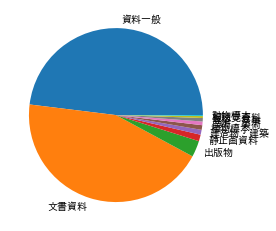

In [9]:
analyze("三重県総合博物館")

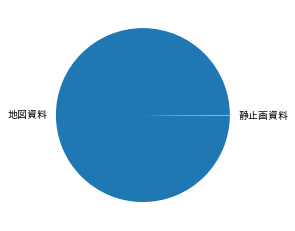

In [10]:
analyze("国土地理院")

In [ ]:
analyze("国立国会図書館")